In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
import json
import sys
import gc

In [5]:
df_restaurantes = pd.read_parquet('Datawarehouse/restaurantes.parquet')
# df_estados = pd.read_parquet('Datawarehouse/estados.parquet')
df_reseñas = pd.read_parquet('Datawarehouse/reviewstexto.parquet')

# Desanidar Atributos (by: Javi)

In [6]:
df_restaurantes = df_restaurantes[df_restaurantes['nombre'] =="Subway"]
df_restaurantes = df_restaurantes[df_restaurantes.nombre.str.contains('Subway')]
df_restaurantes = df_restaurantes.reset_index().drop(columns=['index']).rename_axis('index', axis=0)

In [7]:
columnas = pd.DataFrame(pd.json_normalize(df_restaurantes.atributos).isna().sum(),columns=['nulos']).query("nulos < 6000").index.to_list()
columnas

['Accessibility',
 'Amenities',
 'Atmosphere',
 'Crowd',
 'Dining options',
 'Health & safety',
 'Highlights',
 'Offerings',
 'Payments',
 'Popular for',
 'Service options']

In [8]:
df_atributos = pd.json_normalize(df_restaurantes.atributos).reset_index()[columnas].fillna(np.ndarray([]))

for col in columnas:
    df_atributos[col] = df_atributos[col].apply(str)
    df_atributos[col] = df_atributos[col].apply(lambda c: "[]" if c == '0.0' else c)

In [9]:
def transformar_columnas(df, columnas):
    prefijos = {
        'Accessibility': 'access_',
        'Amenities': 'amen_',
        'Atmosphere': 'atmos_',
        'Crowd': 'crowd_',
        'Dining options': 'dining_',
        'Health & safety': 'health_',
        'Highlights': 'high_',
        'Offerings': 'offer_',
        'Payments': 'pay_',
        'Popular for': 'popular_',
        'Service options': 'service_'
    }
    
    for columna in columnas:
        if columna in df.columns:
            # Paso 1: Limpiar y convertir las comodidades de texto a listas
            def limpiar_y_convertir(s):
                if isinstance(s, str):
                    s = re.sub(r"'", "\"", s)
                    s = re.sub(r'"\s*"', '","', s)
                    try:
                        return json.loads(s)
                    except json.JSONDecodeError:
                        return []
                return []
            
            df[columna] = df[columna].apply(limpiar_y_convertir)
            
            # Paso 2: Identificar todas las comodidades únicas
            unicos = df[columna].explode().unique()[1:].tolist()
            
            # Paso 3: Crear un DataFrame con columnas para cada comodidad
            df_unicos = pd.DataFrame([[False] * len(unicos)] * df.shape[0], columns=unicos)
            
            # Paso 4: Rellenar el DataFrame con valores booleanos
            for i, row in enumerate(df[columna]):
                for val in row:
                    if val in df_unicos.columns:
                        df_unicos.loc[i, val] = True
            
            # Paso 5: Renombrar las columnas usando el diccionario proporcionado
            categoria_prefijo = prefijos.get(columna, '')
            nuevas_columnas = {col: categoria_prefijo + col for col in df_unicos.columns}
            df_unicos.rename(columns=nuevas_columnas, inplace=True)
            
            # Paso 6: Unir el nuevo DataFrame con el DataFrame original
            df = df.reset_index().merge(df_unicos.reset_index(), on='index').drop(columns=['index'])
    
    return df

In [10]:
df_atributos = transformar_columnas(df_atributos, columnas)

In [11]:
df_atributos.drop(columns=columnas, inplace=True, errors='ignore')

In [12]:
df_restaurantes.drop(columns='atributos', inplace=True, errors='ignore')
df_union = df_atributos.rename_axis('index', axis=0).merge(df_restaurantes, on="index")
del df_atributos
del df_restaurantes
df_union.head()

,access_Wheelchair accessible entrance,access_Wheelchair accessible parking lot,access_Wheelchair accessible restroom,access_Wheelchair accessible seating,access_Wheelchair accessible elevator,access_Wheelchair-accessible car park,access_Wheelchair-accessible entrance,access_Wheelchair-accessible seating,access_Wheelchair-accessible toilet,access_Wheelchair-accessible lift,...,service_Outdoor seating,service_Takeaway,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,calificacion
index,,,,,,,,,,,,,,,,,,,,,
0,False,False,False,False,False,False,False,False,False,False,...,False,False,gi90NMmRhzl8vzM83UNOVA,9.0,Subway,"Food, Sandwiches, Restaurants, Fast Food",14,28.150110,-82.353997,3.0
1,False,False,False,False,False,False,False,False,False,False,...,False,False,wXBAAafoiZ4Nty2ajuBtfw,14.0,Subway,"Restaurants, Sandwiches, Fast Food",11,39.884360,-86.067905,2.5
2,False,False,False,False,False,False,False,False,False,False,...,False,False,pFtvNuoUppn9GYx0_ZsW5w,14.0,Subway,"Sandwiches, Restaurants, Fast Food",6,39.910207,-86.183382,2.5
3,False,False,False,False,False,False,False,False,False,False,...,False,False,CmDTNEVReN6CgE6ctlZhag,14.0,Subway,"Sandwiches, Salad, Fast Food, Restaurants",7,39.676701,-86.309883,3.0
4,False,False,False,False,False,False,False,False,False,False,...,False,False,31s1x27DnN2V-ptUWEdfTQ,14.0,Subway,"Sandwiches, Restaurants, Fast Food",7,39.912251,-86.261775,3.5


# Rellenar Atributos con Reseñas

## Reseñas

### Reseñas de Subway

In [64]:
subway_id_list = df_union['id_restaurante'].to_list()

In [65]:
# Filtrar el DataFrame
df_reseñas = df_reseñas[df_reseñas['id_restaurante'].isin(subway_id_list)]
df_reseñas.dropna(how='any', inplace= True)

In [66]:
df_reseñas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24753 entries, 2640 to 12318208
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_usuario              24753 non-null  object 
 1   id_restaurante          24753 non-null  object 
 2   id_resena               24753 non-null  object 
 3   calificacion            24753 non-null  int64  
 4   anio                    24753 non-null  int32  
 5   texto                   24753 non-null  object 
 6   puntaje_de_sentimiento  24753 non-null  float64
dtypes: float64(1), int32(1), int64(1), object(4)
memory usage: 1.4+ MB


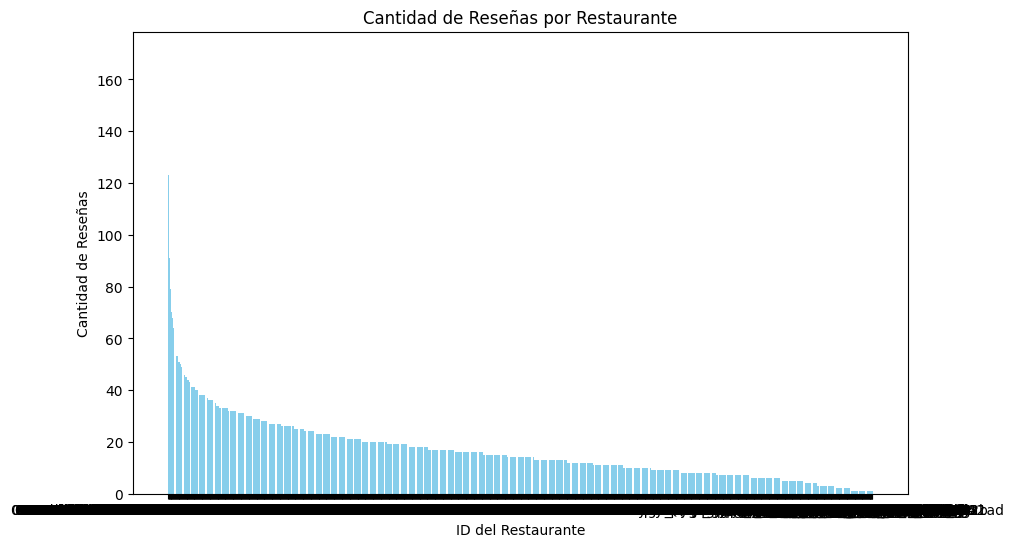

In [67]:
# Paso 1: Contar la cantidad de reseñas por cada local
conteo_reseñas = df_reseñas['id_restaurante'].value_counts().reset_index()
conteo_reseñas.columns = ['id_restaurante', 'cantidad_reseñas']

# Paso 2: Crear el histograma
plt.figure(figsize=(10, 6))
plt.bar(conteo_reseñas['id_restaurante'], conteo_reseñas['cantidad_reseñas'], color='skyblue')
plt.xlabel('ID del Restaurante')
plt.ylabel('Cantidad de Reseñas')
plt.title('Cantidad de Reseñas por Restaurante')
plt.xticks(conteo_reseñas['id_restaurante'])
plt.show()
del conteo_reseñas

### Wordcloud

In [68]:
wordcloud_reseñas = " ".join(df_reseñas['texto'].tolist()).lower()

In [69]:
wordcloud = WordCloud(stopwords = STOPWORDS,
                      collocations=True, background_color='white').generate(wordcloud_reseñas)

wordcloud_reseñas_count = pd.DataFrame(data=[wordcloud.process_text(wordcloud_reseñas)]).T.rename({0:'count'}, axis=1).sort_values(by='count',ascending=False) 

In [70]:
wordcloud_reseñas_count.head(30)

,count
subway,3917
sandwich,2410
food,1886
sub,1792
clean,1692
good,1684
place,1675
one,1629
alway,1515
order,1384


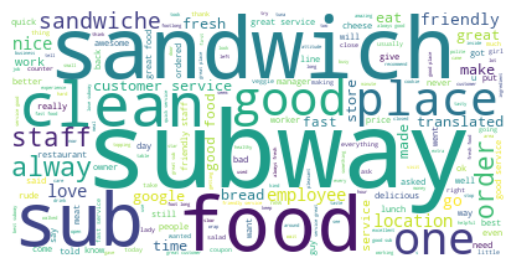

In [71]:
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

In [72]:
del wordcloud_reseñas_count
del wordcloud

## Rellenar Atributos

In [73]:
# Filtrar las reseñas que contienen la palabra 'friendly' y obtener los identificadores de los restaurantes correspondientes
restaurantes_con_friendly = df_reseñas[df_reseñas['texto'].str.contains('friendly', case=False)]['id_restaurante'].unique()

# Actualizar las columnas en el DataFrame de restaurantes basándote en los identificadores obtenidos
for restaurante_id in restaurantes_con_friendly:
    # Actualizar la columna 'crowd_Family friendly' en True para los restaurantes que contienen 'friendly'
    df_union.loc[df_union['id_restaurante'] == restaurante_id, 'crowd_Family friendly'] = True

In [74]:
# Filtrar las reseñas que contienen la palabra 'clean' y obtener los identificadores de los restaurantes correspondientes
restaurantes_con_clean = df_reseñas[df_reseñas['texto'].str.contains('clean', case=False)]['id_restaurante'].unique()

# Actualizar las columnas en el DataFrame de restaurantes basándote en los identificadores obtenidos
for restaurante_id in restaurantes_con_clean:
    # Actualizar la columna 'health_Staff required to disinfect surfaces between visits' en True para los restaurantes que contienen 'clean'
    df_union.loc[df_union['id_restaurante'] == restaurante_id, 'health_Staff required to disinfect surfaces between visits'] = True

In [82]:
columns_no_sum = ['id_restaurante',
 'id_estado',
 'nombre',
 'categorias',
 'cantidad_resenas',
 'latitud',
 'longitud',
 'calificacion']

true_por_columna = df_union.drop(columns=columns_no_sum).sum()  # Sumamos los valores True por columna
df_union.drop(columns=columns_no_sum).columns.to_list()

['access_Wheelchair accessible entrance',
 'access_Wheelchair accessible parking lot',
 'access_Wheelchair accessible restroom',
 'access_Wheelchair accessible seating',
 'access_Wheelchair accessible elevator',
 'access_Wheelchair-accessible car park',
 'access_Wheelchair-accessible entrance',
 'access_Wheelchair-accessible seating',
 'access_Wheelchair-accessible toilet',
 'access_Wheelchair-accessible lift',
 'amen_Good for kids',
 'amen_High chairs',
 'amen_Gender-neutral restroom',
 'amen_Restroom',
 'amen_Wi-Fi',
 'amen_Gender-neutral toilets',
 'amen_Toilets',
 'atmos_Casual',
 'atmos_Cozy',
 'atmos_Trending',
 'crowd_Tourists',
 'crowd_College students',
 'crowd_Groups',
 'crowd_Family-friendly',
 'crowd_University students',
 'crowd_Family friendly',
 'dining_Lunch',
 'dining_Catering',
 'dining_Dessert',
 'dining_Breakfast',
 'dining_Dinner',
 'dining_Seating',
 'health_Staff required to disinfect surfaces between visits',
 'health_Mask required',
 'health_Temperature check r

In [92]:
columnas_service = [col for col in df_union.columns if col.startswith('service')]
columnas_access = [col for col in df_union.columns if col.startswith('access')]
columnas_amen = [col for col in df_union.columns if col.startswith('amen')]
columnas_atmos = [col for col in df_union.columns if col.startswith('atmos')]
columnas_crowd = [col for col in df_union.columns if col.startswith('crowd')]
columnas_dining = [col for col in df_union.columns if col.startswith('dining')]
columnas_health = [col for col in df_union.columns if col.startswith('health')]
columnas_high = [col for col in df_union.columns if col.startswith('high')]
columnas_offer = [col for col in df_union.columns if col.startswith('offer')]
columnas_pay = [col for col in df_union.columns if col.startswith('pay')]
columnas_popular = [col for col in df_union.columns if col.startswith('popular')]

C:\Users\Luka\AppData\Local\Temp\ipykernel_2940\2797122843.py:20: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


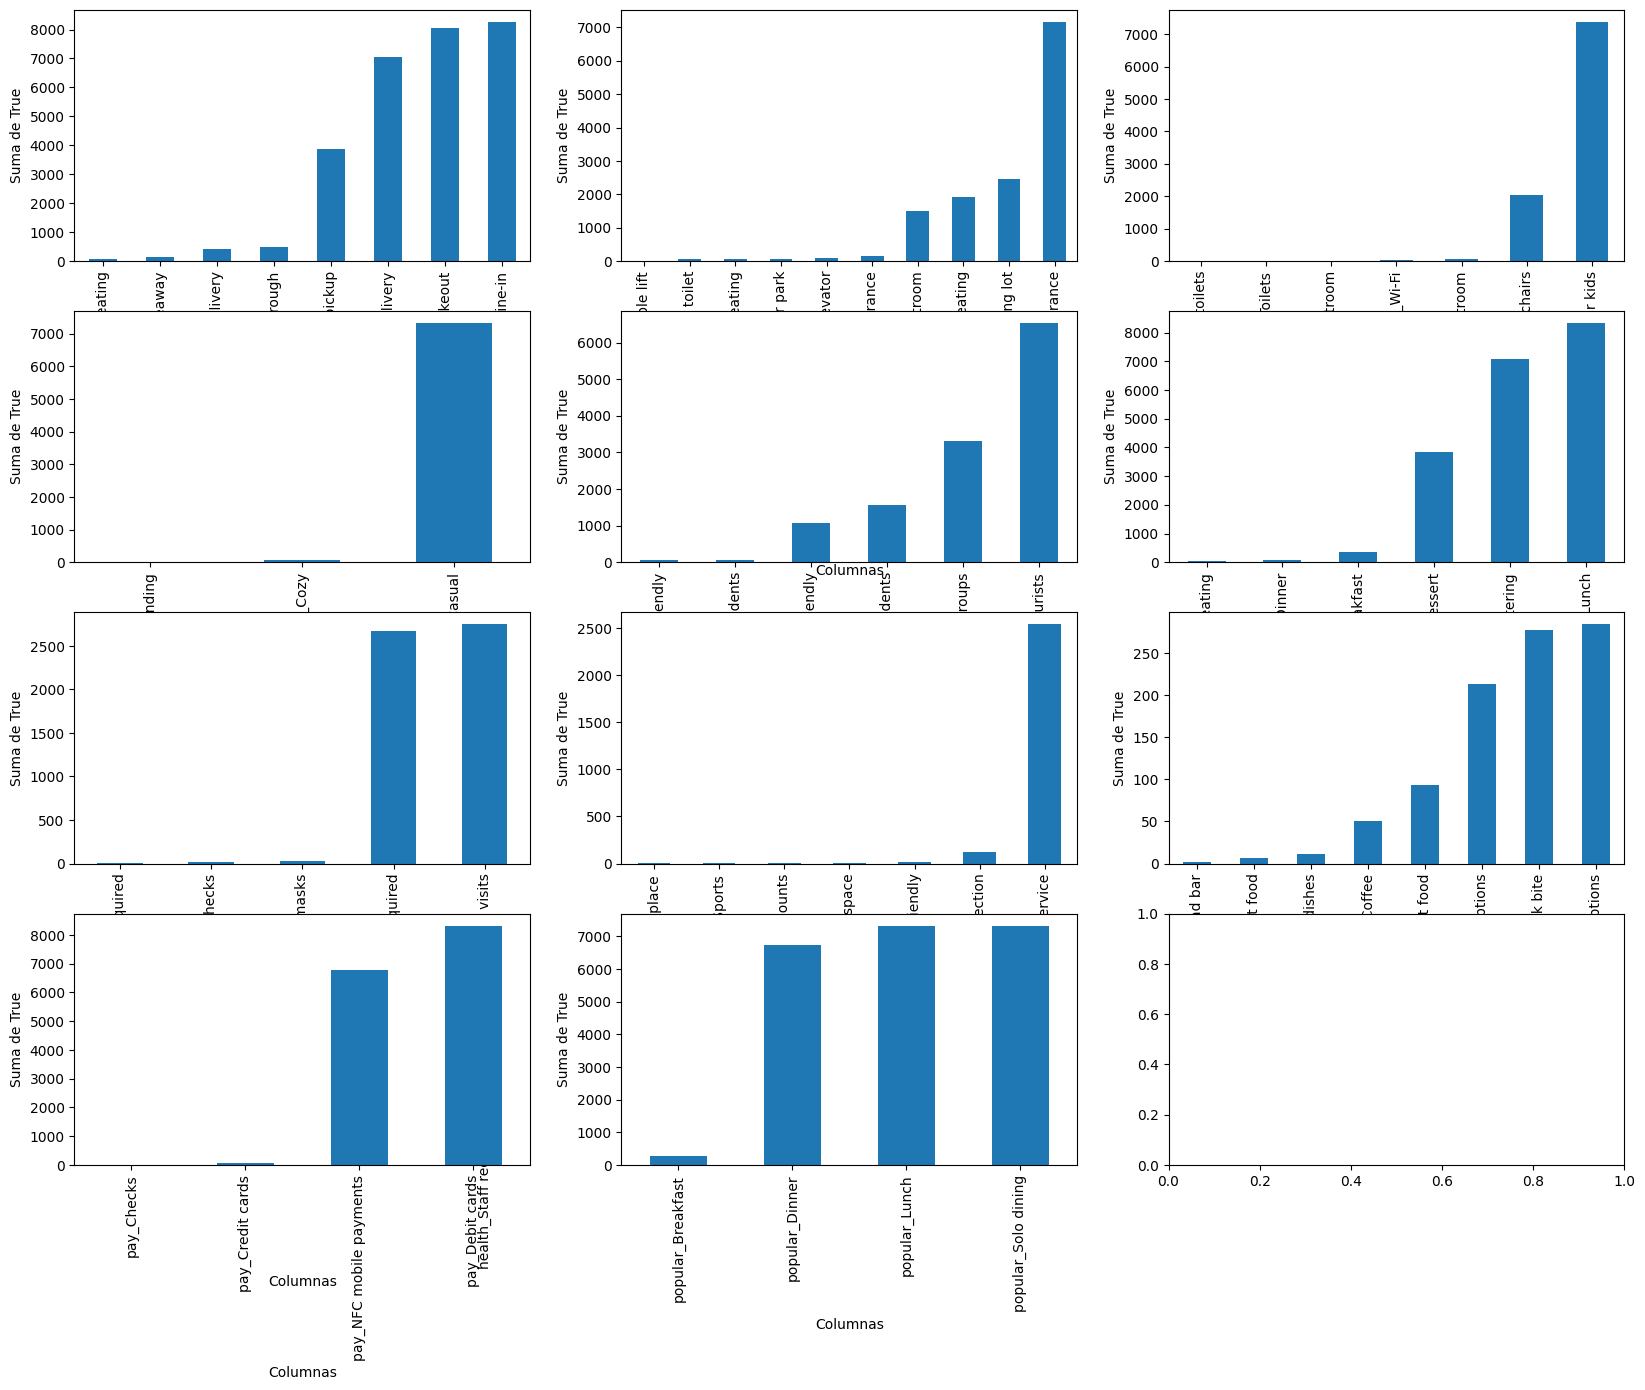

In [99]:
columnas_listas = [columnas_service, columnas_access, columnas_amen, columnas_atmos, 
                   columnas_crowd, columnas_dining, columnas_health, columnas_high, 
                   columnas_offer, columnas_pay, columnas_popular]


# Crear la figura y los subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 15))  # 4 filas, 3 columnas de subplots

# Asegurarnos de que hay exactamente 11 subplots
axes = axes.flatten()[:11]

# Iterar sobre cada lista de columnas y cada subplot
for i, (columnas, ax) in enumerate(zip(columnas_listas, axes)):
    true_counts = df_union[columnas].sum().sort_values()
    true_counts.plot(kind='bar', ax=ax)
    ax.set_xlabel('Columnas')
    ax.set_ylabel('Suma de True')

# Ajustar el diseño de la figura
plt.tight_layout()
plt.show()

# Puntaje de Restaurantes 

# Modelo no supervisado - Clustering

## Preparación de datos

In [29]:
X = df_union.drop(columns=['id_restaurante', 'id_estado', 'id_estado', 'nombre', 'categorias',])

In [30]:
# Crear instancias de los escaladores
scaler_lat_lon = MinMaxScaler()
scaler_calificacion = MinMaxScaler()  # Normalización
scaler_cantidad_resenas = StandardScaler()  # Z-score Scaling

In [31]:
# Seleccionar las columnas relevantes
columnas_lat_lon = ['latitud', 'longitud']
columna_calificacion = ['calificacion']
columna_cantidad_resenas = ['cantidad_resenas']

# Aplicar el escalamiento a cada columna por separado
X[columnas_lat_lon] = scaler_lat_lon.fit_transform(X[columnas_lat_lon])
X[columna_calificacion] = scaler_calificacion.fit_transform(X[columna_calificacion])
X[columna_cantidad_resenas] = scaler_cantidad_resenas.fit_transform(X[columna_cantidad_resenas])

In [32]:
X.head()

,access_Wheelchair accessible entrance,access_Wheelchair accessible parking lot,access_Wheelchair accessible restroom,access_Wheelchair accessible seating,access_Wheelchair accessible elevator,access_Wheelchair-accessible car park,access_Wheelchair-accessible entrance,access_Wheelchair-accessible seating,access_Wheelchair-accessible toilet,access_Wheelchair-accessible lift,...,service_Takeout,service_Dine-in,service_Drive-through,service_No-contact delivery,service_Outdoor seating,service_Takeaway,cantidad_resenas,latitud,longitud,calificacion
index,,,,,,,,,,,,,,,,,,,,,
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,-1.066134,0.291070,0.841942,0.500
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,-1.135787,0.691584,0.801498,0.375
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,-1.251875,0.692466,0.800241,0.375
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,-1.228657,0.684496,0.798863,0.500
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,-1.228657,0.692536,0.799387,0.625


## Método del codo

In [171]:
# Determinar el número óptimo de clusters usando el método del codo para K-Means
wcss_kmeans = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
    wcss_kmeans.append(kmeans.inertia_)

# Determinar el número óptimo de clusters usando el método del codo para DBSCAN
def dbscan_optimal_clusters(X, epsilon):
    dbscan = DBSCAN(eps=epsilon, min_samples=5)
    dbscan.fit(X)
    return len(np.unique(dbscan.labels_))

eps_values = np.linspace(0.1, 2.0, num=20)
num_clusters_dbscan = [dbscan_optimal_clusters(X, eps) for eps in eps_values]

# Función para calcular los puntos de codo
def agglomerative_optimal_clusters(X):
    distances = []
    # Probar diferentes criterios de enlace
    for linkage in ['ward', 'complete', 'average', 'single']:
        # Ejecutar Agglomerative Clustering
        agg_cluster = AgglomerativeClustering(n_clusters=None, linkage=linkage, distance_threshold=0)
        agg_cluster.fit(X)
        # Obtener la distancia entre los puntos en el dendrograma
        distances.append(agg_cluster.distances_)

    # Calcular los puntos de codo para cada criterio de enlace
    elbow_points = []
    for dist in distances:
        # Calcular la diferencia entre distancias sucesivas
        differences = np.diff(dist[::-1])
        # Encontrar el punto de codo
        elbow_index = np.argmax(differences < np.mean(differences))
        elbow_points.append(len(dist) - elbow_index)

    return elbow_points

# Calcular los puntos de codo
num_clusters_agg = agglomerative_optimal_clusters(X)


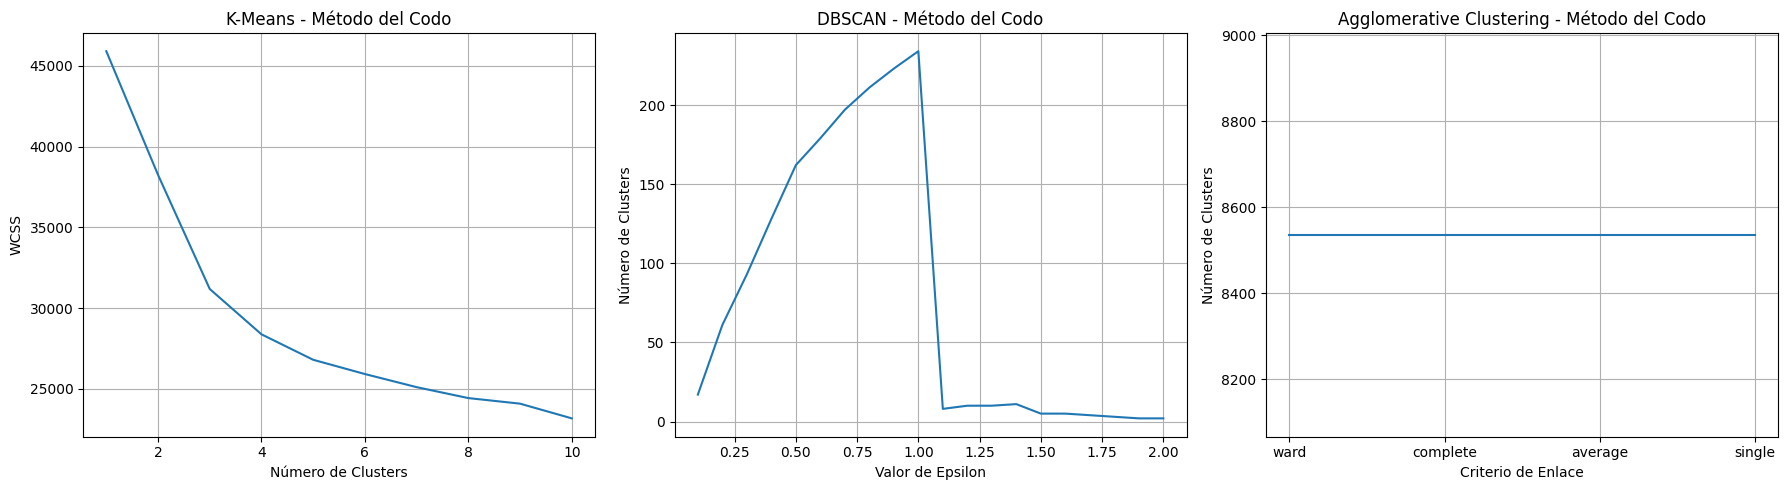

In [ ]:
# Graficar los resultados
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico para K-Means
axes[0].plot(range(1, 11), wcss_kmeans)
axes[0].set_title('K-Means - Método del Codo')
axes[0].set_xlabel('Número de Clusters')
axes[0].set_ylabel('WCSS')
axes[0].grid(True)  # Agregar grid al primer gráfico

# Gráfico para DBSCAN
axes[1].plot(eps_values, num_clusters_dbscan)
axes[1].set_title('DBSCAN - Método del Codo')
axes[1].set_xlabel('Valor de Epsilon')
axes[1].set_ylabel('Número de Clusters')
axes[1].grid(True)  # Agregar grid al segundo gráfico

# Gráfico para Agglomerative Clustering
axes[2].plot(['ward', 'complete', 'average', 'single'], num_clusters_agg)
axes[2].set_title('Agglomerative Clustering - Método del Codo')
axes[2].set_xlabel('Criterio de Enlace')
axes[2].set_ylabel('Número de Clusters')
axes[2].grid(True)  # Agregar grid al tercer gráfico

plt.tight_layout()
plt.show()


## Reducción de dimensionalidades

In [33]:
# Realizar t-SNE para reducir la dimensionalidad a 3 dimensiones
tsne_3 = TSNE(n_components=3, random_state=42)
X_tsne_3 = tsne_3.fit_transform(X.values)

# Realizar la reducción de dimensionalidad utilizando PCA con 3 componentes principales
pca_3 = PCA(n_components=3)
X_pca_3 = pca_3.fit_transform(X.values)

In [34]:
# Realizar t-SNE para reducir la dimensionalidad a 2 dimensiones
tsne_2 = TSNE(n_components=2, random_state=42)
X_tsne_2 = tsne_2.fit_transform(X.values)

# Realizar la reducción de dimensionalidad utilizando PCA con 2 componentes principales
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X.values)

## Modelos de clustering

In [49]:
n_clusters = 2
v_eps = 0.5
min_samples = 3

### KMeans

In [50]:
# Crear el modelo de clustering
kmeans_3d_tsne = KMeans(n_clusters=n_clusters, random_state=42)

# Ajustar el modelo a tus datos (sin tener en cuenta el índice)
labels_kmeans_3d_tsne = kmeans_3d_tsne.fit_predict(X_tsne_3)

In [51]:
# Crear el modelo de clustering
kmeans_3d_pca = KMeans(n_clusters=n_clusters, random_state=42)

# Ajustar el modelo a tus datos (sin tener en cuenta el índice)
labels_kmeans_3d_pca = kmeans_3d_pca.fit_predict(X_pca_3)

In [52]:
# Crear el modelo de clustering
kmeans_2d_tsne = KMeans(n_clusters=n_clusters, random_state=42)

# Ajustar el modelo a tus datos (sin tener en cuenta el índice)
labels_kmeans_2d_tsne = kmeans_2d_tsne.fit_predict(X_tsne_2)

In [53]:
# Crear el modelo de clustering
kmeans_2d_pca = KMeans(n_clusters=n_clusters, random_state=42)

# Ajustar el modelo a tus datos (sin tener en cuenta el índice)
labels_kmeans_2d_pca = kmeans_2d_pca.fit_predict(X_pca_2)

### DBSCAN

In [54]:
# Crear el modelo DBSCAN
dbscan_3d_tsne = DBSCAN(eps=v_eps, min_samples=min_samples)
labels_dbscan_3d_tsne = dbscan_3d_tsne.fit_predict(X_tsne_3)

In [55]:
# Crear el modelo DBSCAN
dbscan_3d_pca = DBSCAN(eps=v_eps, min_samples=min_samples)
labels_dbscan_3d_pca = dbscan_3d_pca.fit_predict(X_pca_3)

In [56]:
# Crear el modelo DBSCAN
dbscan_2d_tsne = DBSCAN(eps=v_eps, min_samples=min_samples)
labels_dbscan_2d_tsne = dbscan_2d_tsne.fit_predict(X_tsne_2)

In [57]:
# Crear el modelo DBSCAN
dbscan_2d_pca = DBSCAN(eps=v_eps, min_samples=min_samples)
labels_dbscan_2d_pca = dbscan_2d_pca.fit_predict(X_pca_2)

### KMeans Visualización

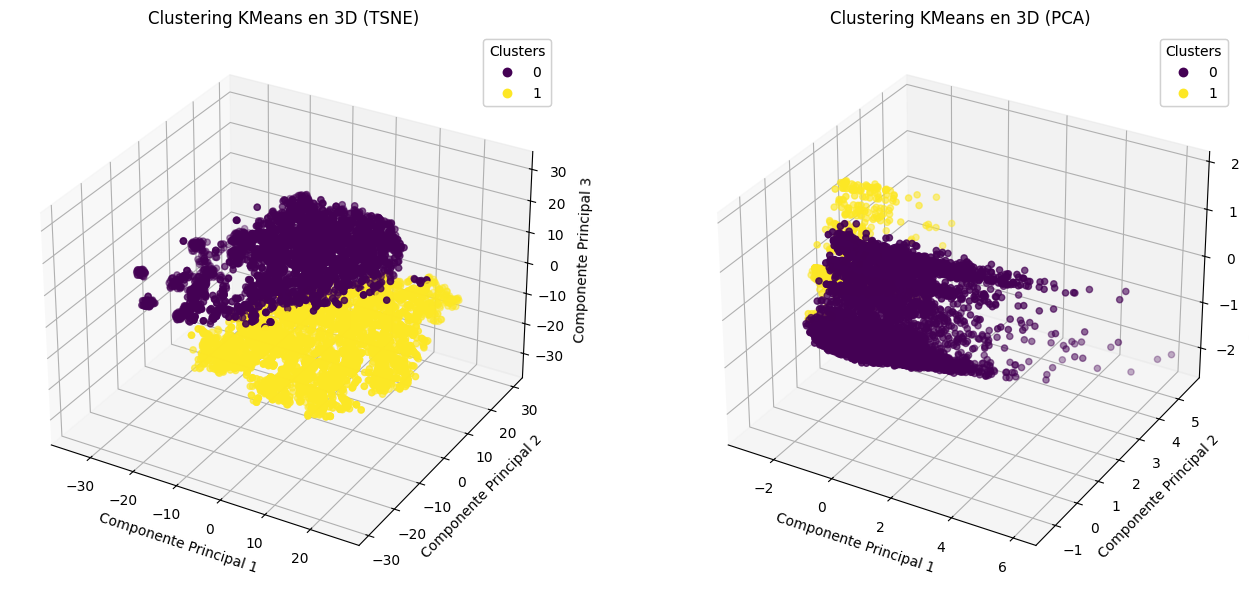

In [58]:
# Crear subplots
fig = plt.figure(figsize=(14, 6))

# Gráfico 3D para KMeans
ax1 = fig.add_subplot(121, projection='3d')
scatter_kmeans = ax1.scatter(X_tsne_3[:, 0], X_tsne_3[:, 1], X_tsne_3[:, 2], c=labels_kmeans_3d_tsne, cmap='viridis')
ax1.set_title('Clustering KMeans en 3D (TSNE)')
ax1.set_xlabel('Componente Principal 1')
ax1.set_ylabel('Componente Principal 2')
ax1.set_zlabel('Componente Principal 3')
legend1 = ax1.legend(*scatter_kmeans.legend_elements(), title="Clusters")
ax1.add_artist(legend1)

# Gráfico 3D para DBSCAN
ax2 = fig.add_subplot(122, projection='3d')
scatter_dbscan = ax2.scatter(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2], c=labels_kmeans_3d_pca, cmap='viridis')
ax2.set_title('Clustering KMeans en 3D (PCA)')
ax2.set_xlabel('Componente Principal 1')
ax2.set_ylabel('Componente Principal 2')
ax2.set_zlabel('Componente Principal 3')
legend2 = ax2.legend(*scatter_dbscan.legend_elements(), title="Clusters")
ax2.add_artist(legend2)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

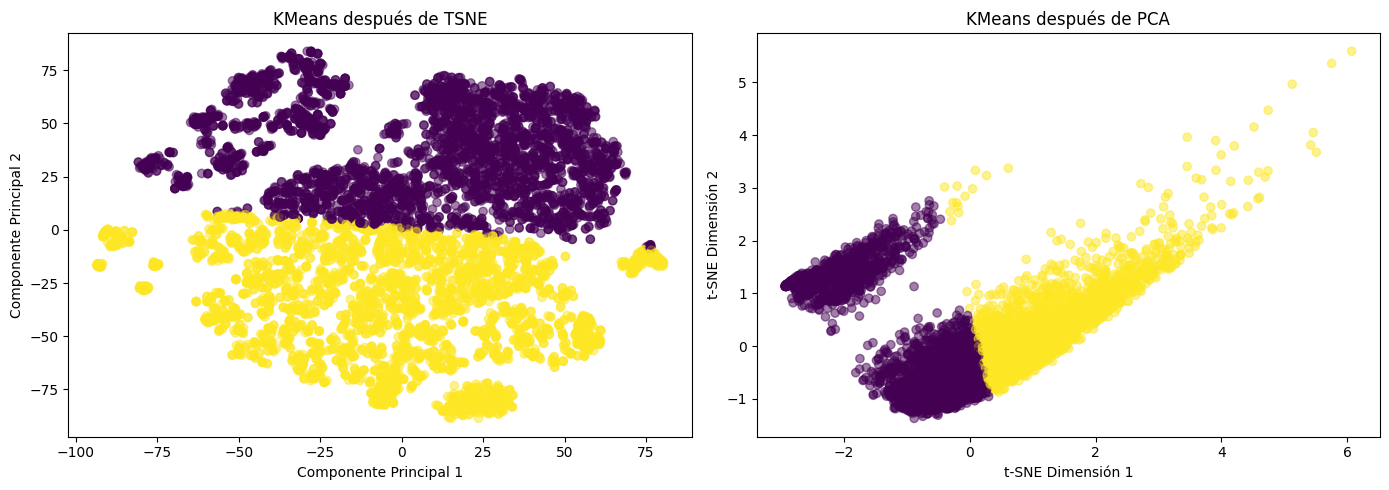

In [59]:
# Crear subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot de los clusters para PCA
ax[0].scatter(X_tsne_2[:, 0], X_tsne_2[:, 1], c=labels_kmeans_2d_tsne, cmap='viridis', alpha=0.5)
ax[0].set_xlabel('Componente Principal 1')
ax[0].set_ylabel('Componente Principal 2')
ax[0].set_title('KMeans después de TSNE')

# Scatter plot de los clusters para t-SNE
ax[1].scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=labels_kmeans_2d_pca, cmap='viridis', alpha=0.5)
ax[1].set_xlabel('t-SNE Dimensión 1')
ax[1].set_ylabel('t-SNE Dimensión 2')
ax[1].set_title('KMeans después de PCA')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### DBSCAN Visualización

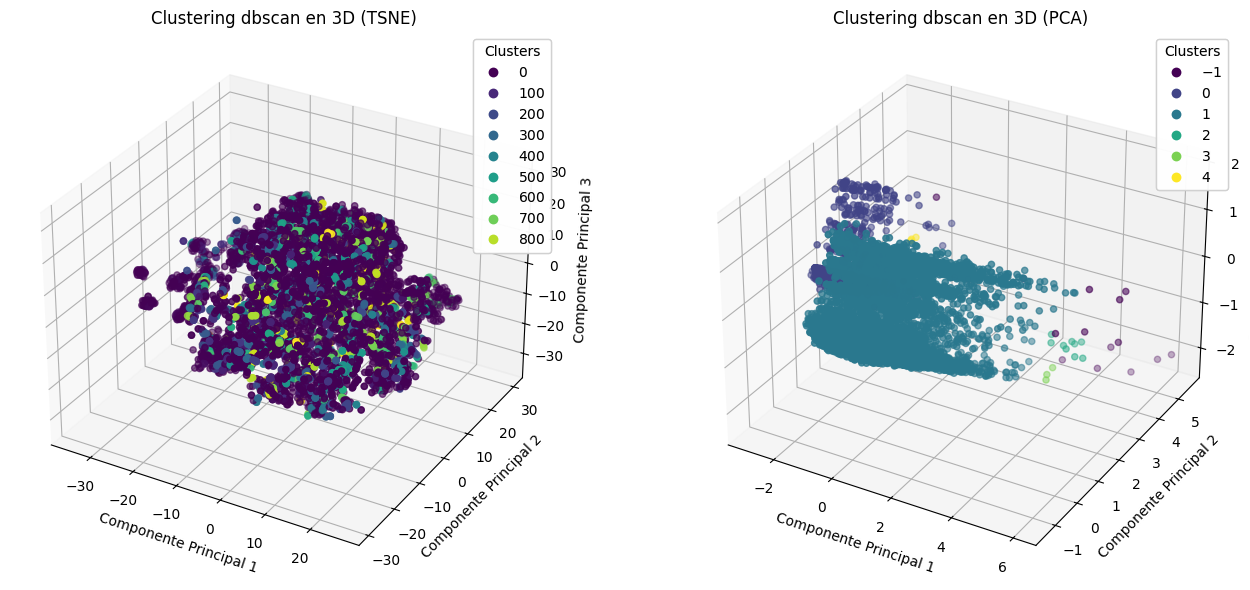

In [60]:
# Crear subplots
fig = plt.figure(figsize=(14, 6))

# Gráfico 3D para dbscan
ax1 = fig.add_subplot(121, projection='3d')
scatter_dbscan = ax1.scatter(X_tsne_3[:, 0], X_tsne_3[:, 1], X_tsne_3[:, 2], c=labels_dbscan_3d_tsne, cmap='viridis')
ax1.set_title('Clustering dbscan en 3D (TSNE)')
ax1.set_xlabel('Componente Principal 1')
ax1.set_ylabel('Componente Principal 2')
ax1.set_zlabel('Componente Principal 3')
legend1 = ax1.legend(*scatter_dbscan.legend_elements(), title="Clusters")
ax1.add_artist(legend1)

# Gráfico 3D para DBSCAN
ax2 = fig.add_subplot(122, projection='3d')
scatter_dbscan = ax2.scatter(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2], c=labels_dbscan_3d_pca, cmap='viridis')
ax2.set_title('Clustering dbscan en 3D (PCA)')
ax2.set_xlabel('Componente Principal 1')
ax2.set_ylabel('Componente Principal 2')
ax2.set_zlabel('Componente Principal 3')
legend2 = ax2.legend(*scatter_dbscan.legend_elements(), title="Clusters")
ax2.add_artist(legend2)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

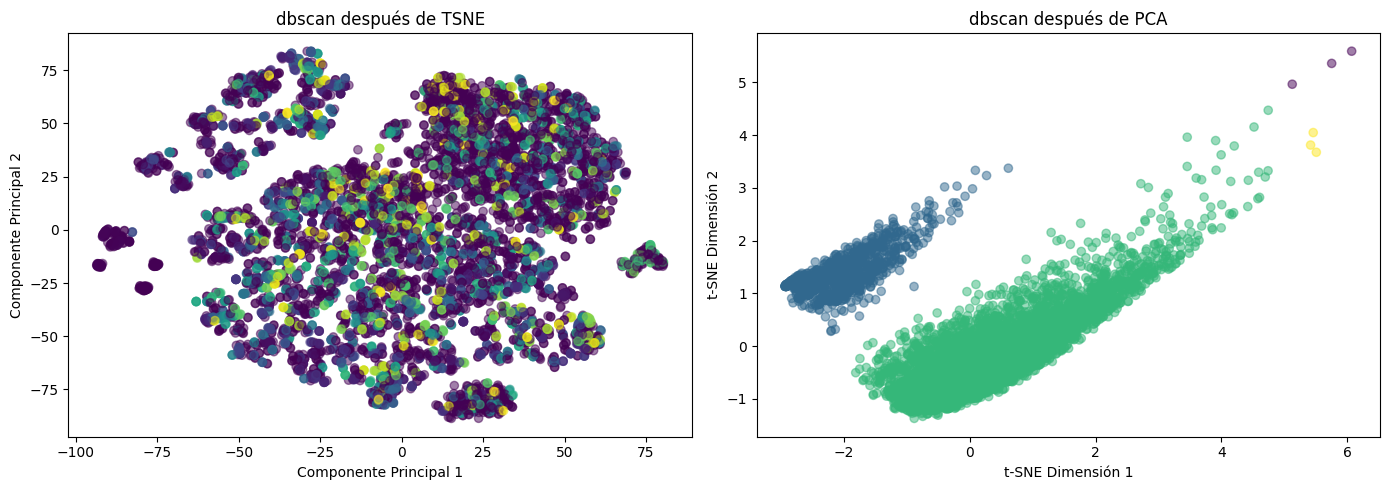

In [63]:
# Crear subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot de los clusters para PCA
ax[0].scatter(X_tsne_2[:, 0], X_tsne_2[:, 1], c=labels_dbscan_2d_tsne, cmap='viridis', alpha=0.5)
ax[0].set_xlabel('Componente Principal 1')
ax[0].set_ylabel('Componente Principal 2')
ax[0].set_title('dbscan después de TSNE')

# Scatter plot de los clusters para t-SNE
ax[1].scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=labels_dbscan_2d_pca, cmap='viridis', alpha=0.5)
ax[1].set_xlabel('t-SNE Dimensión 1')
ax[1].set_ylabel('t-SNE Dimensión 2')
ax[1].set_title('dbscan después de PCA')

# Mostrar el gráfico
plt.tight_layout()
plt.show()